[Chapter 7] Fine-tuning to follow instructions

preparing dataset for supervised instruction fine-tuning

In [53]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("number of entries:", len(data))

number of entries: 1100


In [54]:
print("example entry:\n", data[50])
# python dictionary objects containing "instruction", "input" and "output"

example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [55]:
print("another example entry:\n", data[999])

another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [56]:
# prompt formatting function

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )

    return instruction_text + input_text

In [57]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response: \n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response: 
The correct spelling is 'Occasion.'


In [58]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response: \n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response: 
An antonym of 'complicated' is 'simple'.


In [59]:
# partitioning the dataset

# use 85% data for training
train_portion = int(len(data) * 0.85)
# use 10% data for testing
test_portion = int(len(data) * 0.1)
# use remaining 5% for vaidation
val_portion = len(data) - train_portion - test_portion


train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]


print("training set length:", len(train_data))
print("validation set length:", len(val_data))
print("test set length:", len(test_data))

training set length: 935
validation set length: 55
test set length: 110


organizing data into training batches

In [60]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            # pretokenize texts
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))
        
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [61]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [62]:
def custom_collate_draft_1(batch, pad_token_id=50256, device='cpu'):
    # find the longest sequence in the batch (while allowing diff batches have diff length)
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []
    # pad and prepare inputs
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # remove extra padded token added earlier
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [63]:
# test and verify
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [64]:
def custom_collate_draft_2(
        batch,
        pad_token_id=50256,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        # similar toe the process we used to pretrain LLM
        # target token ids match the input token ids but are shifted one position to the right 
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)    

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [65]:
# custom batch collate function
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device='cpu'):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        # pad sequence to max_length
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # truncate the last token for inputs (given end with 50256 even before padded)
        inputs = torch.tensor(padded[:-1])
        # shift +1 to the right for targets
        targets = torch.tensor(padded[1:])
        
        # replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id  # 1 if pad_token_id 
        indices = torch.nonzero(mask).squeeze()  
        if indices.numel() > 1:
            # assign -100 value to all padding tokens: allow us to exclude these padding tokens from contirbuting to the training loss calculation
            #                                          no need to fine-tune for classificaiton given training is only based on last ouput token 
            # reain one 50256 in the target list to allow LLM to learn when to generate an end-of-text token in repsonse to instruction
            targets[indices[1:]] = ignore_index
        
        # optionally truncate to the max sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor

In [66]:
# test and try
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [67]:
logits_1 = torch.tensor(
    [[-1.0, 1.0], # predictions for 1st token
     [-0.5, 1.5]] # predictions for 2nd token
)
targets_1 = torch.tensor([0, 1]) # actual/correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [68]:
# adding an additional token id affects the loss calculation

logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [69]:
# if we replace the third target token id with -100

targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

# corss entropy loss func igonored the third entry of -100
# masking out insturctions: besides masking out padding tokens, also common to mask out the target token ids corresponding to instructions.
#                           the cross entropy then only compute for the generated response target ids
#                           the model is trained to focus on generating accruate response not memorizing instructions (reducing overfiting)
#                           however, research shows not masking the instructions benefitting the LLM performance

tensor(1.1269)
loss_1 == loss_3: tensor(True)


creating data loaders from an instruction dataset

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# uncomment below two lines to use the gpu on apple silicon chip
# if torch.backends.mps.is_available():
#    device = torch.device("mps")
print("device:", device)

device: cpu


In [71]:
# create a new version of the function with the device argument prefilled
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0 # can increase this number if parallel python processes are suported by os
                # adapted to specific dataset ize and computation environment
                # set num_workers=4 usually leads to optimal performance
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [73]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

# 8 represents the batch size, 62 is the number of tokens in each training example
# able to create batches of different lengths (thanks to custom collate func)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

loading a pretrained LLM

In [74]:
from gpt_download import download_and_load_gpt2

import import_ipynb
from ch4 import GPTModel
from ch5 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,       # vocab size
    "context_length": 1024,    # context length
    "drop_rate": 0.0,          # dorpout rate
    "qkv_bias": True           # query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-x1 (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)" # different with book, to save some time given my hardware contraint, i use small model here
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir='gpt2'
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [84]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
from ch5 import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\nThe chef cooks the meal every day."

In [ ]:
# isolate model's reponse text
response_text = generated_text[len(input_text):].strip()
print(response_text)

# the result shows that the pretrained model is not yet capable of correctly following the given instruction
# it simply repeats the original input sentence and part of the instruction, failing to convert the active sentence to passive voice as requested

### Response:
The chef cooks the meal every day.


Fine-tuning the LLM on instruction data

In [78]:
from ch5 import(
    calc_loss_loader,
    train_model_simple
)

In [ ]:
model.to(device)
torch.manual_seed(123)

# torch.no_grad means we use the model for inference only (no need to keep track of gradients, use a network without training or backpropagation)
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )

print("training loss:", train_loss)
print("validation loss:", val_loss)

training loss: 0.4401358664035797
validation loss: 0.7419604539871216


In [80]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step  00000):train loss  3.119 ,val loss  3.069
Ep 1 (Step  00005):train loss  1.696 ,val loss  1.570
Ep 1 (Step  00010):train loss  1.096 ,val loss  1.164
Ep 1 (Step  00015):train loss  1.053 ,val loss  1.083
Ep 1 (Step  00020):train loss  0.970 ,val loss  1.038
Ep 1 (Step  00025):train loss  0.919 ,val loss  1.002
Ep 1 (Step  00030):train loss  0.960 ,val loss  0.978
Ep 1 (Step  00035):train loss  0.877 ,val loss  0.951
Ep 1 (Step  00040):train loss  0.847 ,val loss  0.943
Ep 1 (Step  00045):train loss  0.777 ,val loss  0.925
Ep 1 (Step  00050):train loss  0.869 ,val loss  0.911
Ep 1 (Step  00055):train loss  0.923 ,val loss  0.893
Ep 1 (Step  00060):train loss  0.872 ,val loss  0.877
Ep 1 (Step  00065):train loss  0.800 ,val loss  0.867
Ep 1 (Step  00070):train loss  0.694 ,val loss  0.860
Ep 1 (Step  00075):train loss  0.706 ,val loss  0.855
Ep 1 (Step  00080):train loss  0.753 ,val loss  0.847
Ep 1 (Step  00085):train loss  0.680 ,val loss  0.836
Ep 1 (Step  00090):train los

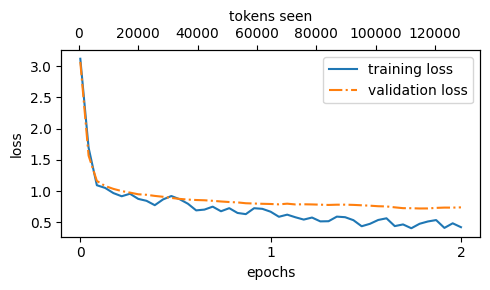

In [81]:
# plot loss
from ch5 import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
# the result indicates that the training is effective

In [ ]:
torch.manual_seed(123)

# iterate over the first three test set samples
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("---------------------------------")

    # based on the results, the model performs relatively well

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.
---------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a tropical rainforest.
---------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride a

In [90]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    # indent for pretty printing
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [05:22<00:00,  2.94s/it]


In [91]:
# verify: the responses have been added the test_set 
print(test_data[0])

# the output shows that the model responses have been added correctly

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a horse.'}


In [ ]:
# save model
import re

# remove white space and parentheses from filename
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
torch.save(model.state_dict(),file_name)
print(f"Mode saved as {file_name}")

# the saved model can be loaded via below
# model.load_state_dict(torch.load("gpt2-small124M-sft.pth"))

Mode saved as gpt2-small124M-sft.pth


Evaluate the fine-tuned LLM

automated conversational benchmarks: evaluate responses auomatically using another LLM

In [94]:
# with ollama session running on background
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(['name']):
        if process_name in proc.info['name']:
            running = True
            break
    return running

ollama_running = check_if_running('ollama')

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before processing.")

print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [99]:
# querying a local Ollama model

import urllib.request

def query_model(
        prompt,
        model='llama3',
        url="http://localhost:11434/api/chat"
):
    # create data payload as a dictionary
    data = {"model": model,
            "messages": [{"role": "user", "content": prompt}],
            # setttings for deterministic responses
            "options": {"seed": 123, "temperature": 0, "num_ctx": 2048}}
    
    # convert the dict to a json-formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")
    # create a request object, setting method to POST and add necessay headers
    request = urllib.request.Request(
        url,
        data=payload,
        method='POST'
    )        

    request.add_header("Content-Type", "application/json")

    # send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

In [100]:
# test and try

model = "llama3"
result = query_model("What does Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and digestive system.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, like willow or cedar.
2. Bark: In some cases, llamas may eat the bar

In [102]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input '{format_input(entry)}'"
        f"and correct output '{entry['output']}', "
        f"score the model response '{entry['model_response']}'"
        f" on a scale from 0 to 100, where 100 is the best score."
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry['model_response'])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-----------------------------------")

# the generated response show that the Llama 3 model provides reasonable evaluations
# and is capable of assigning partial points when a model's answer is not entirely correct


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.

Score:
>> To evaluate the model's response, I'll compare it to the expected output and consider factors such as relevance, coherence, and overall quality.

Expected output: The car is as fast as lightning.
Model response: The car is as fast as a horse.

Score: 60

Reasoning:

* Relevance: The model's response is somewhat relevant to the original sentence, as it attempts to compare the car's speed to that of an animal. However, using a horse as a comparison is not as striking or evocative as lightning.
* Coherence: The model's response is coherent and easy to understand, but it may not be as vivid or memorable as the expected output.
* Overall quality: While the model's response is not bad, it could be improved by choosing a more unexpected or surprising comparison that better captures the essence of the original sentence.

To achieve a higher score, the model could consider using 

In [ ]:
# modify the prompt to just generate integer scores raning from 0 to 100

def generate_model_scores(json_data, json_key, model='llama3'):
    scores=[]
    for entry in tqdm(json_data, desc='Scoring entries'):
        # modified instruction line to only return the score
        prompt = (
            f"Given the input '{format_input(entry)}'"
            f"and correct output '{entry['output']}', "
            f"score the model response '{entry['model_response']}'"
            f" on a scale from 0 to 100, where 100 is the best score."
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    
    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores) / len(scores):.2f}\n")
# the average score is relatively low at 39.19 (vs. 50.32 using meidum model in book)

# the average score provides a useful benchmark for comparison against other models 
# (or for experimenting with different training configuarion to improve the model's performance)

# Ollama is not entirely deterministic: the scores you obtain might vary slightly from the previous scores
#                                       to obtain more robust results, can repeat the evaluation multiple times and average the resulting scores

# to futher improve model performance:
# - adjust the hyperparameters during fine-tunning
# - increase the size of the training dataset or diversifying the examples to cover a broader range of topics and styles
# - experiement different prompts or instruction ormats
# - use a larger pretrained model

Scoring entries: 100%|██████████| 110/110 [30:46<00:00, 16.78s/it]

Number of scores: 110 of 110
Average score: 39.19

